# Feature importance

I will explore the importance of the features using Univariate. Plan of attck is as follows:
1. Reduce training data set down to last month only (i.e. May 2016)
2. Clean data
3. Split up the 24 products and compute feature importance for each product
4. Summarise findings

This is my first attempt to compute feature importance, any comments and suggestions are welcome.

**_If you find this notebook useful, I shall be grateful for any upvote :)_**

## 1) Reduce training data set to last month

In [1]:
f = open('./input/train_ver2.csv','r')
g = open('last_month.csv','w')

for line in f:
    date = line[:10]
    if date == '2016-05-28':
        g.write(line)

In [2]:
with open('../input/train_ver2.csv', 'r') as f:
    cols = f.readline().split(',')

In [3]:
cols = [s.replace('"', '') for s in cols]

## 2) Data Cleaning

In [4]:
import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv('last_month.csv',dtype={'indrel_1mes': str, 'conyuemp':str},names=cols)

In [6]:
df_features = df.iloc[:,:24]

In [7]:
df_features.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-05-28,657640,N,ES,H,68,2006-11-17,0,114,1,...,N,NaN,KAQ,N,1,28.0,MADRID,0,147347.97,02 - PARTICULARES
1,2016-05-28,657788,N,ES,H,42,2006-11-18,0,114,1,...,N,NaN,KBF,N,1,28.0,MADRID,1,132559.35,02 - PARTICULARES
2,2016-05-28,657795,N,ES,V,44,2006-11-18,0,114,1,...,N,NaN,KAP,N,1,26.0,"RIOJA, LA",1,81399.57,02 - PARTICULARES
3,2016-05-28,657790,N,ES,V,42,2006-11-18,0,114,1,...,N,NaN,KBF,N,1,48.0,BIZKAIA,1,NaN,02 - PARTICULARES
4,2016-05-28,657794,N,ES,H,49,2006-11-18,0,114,1,...,N,NaN,KAT,N,1,8.0,BARCELONA,1,102189.00,01 - TOP


Remove irrelevant features

In [8]:
del df_features['fecha_dato']
del df_features['ncodpers']

In [9]:
df_features['tipodom'].value_counts()

1    931429
Name: tipodom, dtype: int64

'tipodom' has only one value -> remove

In [10]:
del df_features['tipodom']

Proportion of null values within each feature:

In [11]:
(df_features.isnull().sum()/len(df_features)).sort_values()

ind_empleado             0.000000
pais_residencia          0.000000
age                      0.000000
fecha_alta               0.000000
ind_nuevo                0.000000
antiguedad               0.000000
indrel                   0.000000
ind_actividad_cliente    0.000000
indresi                  0.000000
indext                   0.000000
indfall                  0.000000
sexo                     0.000005
nomprov                  0.004286
cod_prov                 0.004286
tiprel_1mes              0.004304
indrel_1mes              0.004304
canal_entrada            0.007191
segmento                 0.007541
renta                    0.245872
ult_fec_cli_1t           0.997992
conyuemp                 0.999878
dtype: float64

Dumping 'ult_fec_cli_1t' and 'conyuemp'

In [12]:
del df_features['ult_fec_cli_1t']
del df_features['conyuemp']

Label encode all categorical features (this will replace null values in categorical features with a value)

In [13]:
from sklearn import preprocessing

for f in df_features.columns:
    if df_features[f].dtype == 'object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_features[f].values))
        df_features[f] = lbl.transform(list(df_features[f].values))

ind_empleado
pais_residencia
sexo
fecha_alta
indrel_1mes
tiprel_1mes
indresi
indext
canal_entrada
indfall
nomprov
segmento


The idea is to replace the null values of 'renta' with appropriate median values. To do so, get most correlated features for 'renta' ...

In [14]:
df_features.corr()['renta'].sort_values()

fecha_alta              -0.079895
canal_entrada           -0.059381
segmento                -0.057267
tiprel_1mes             -0.028969
cod_prov                -0.016736
nomprov                 -0.010990
indext                  -0.006829
ind_empleado            -0.004824
indresi                 -0.002060
ind_nuevo               -0.001204
indrel                   0.000206
pais_residencia          0.002149
antiguedad               0.002702
sexo                     0.006908
indfall                  0.008091
indrel_1mes              0.011299
ind_actividad_cliente    0.023142
age                      0.064450
renta                    1.000000
Name: renta, dtype: float64

'segmento' and 'ind_actividad_cliente' seem reasonable and relevant fetaures to group by to get the median for 'renta':

In [15]:
df_features['segmento'].value_counts()

1    542595
2    346395
0     35415
3      7024
Name: segmento, dtype: int64

In [16]:
df_features['ind_actividad_cliente'].value_counts()

0    535711
1    395718
Name: ind_actividad_cliente, dtype: int64

Calculate median values for 'renta' grouped by 'segmento' and 'ind_actividad_cliente'

In [17]:
median_renta = np.zeros((2,4))
for i in range(2):
    for j in range (4):
        median_renta[i][j] = df_features[(df_features['ind_actividad_cliente'] == i) & \
                                         (df_features['segmento'] == j)]['renta'].dropna().median()

In [18]:
median_renta

array([[ 132589.44 ,  103812.39 ,   88230.   ,  127941.93 ],
       [ 141126.48 ,  110529.975,   91964.85 ,   97828.77 ]])

Replace null values with median values

In [19]:
for i in range(0, 2):
    for j in range(0, 4):
        df_features.loc[(df_features['renta'].isnull()) & \
                        (df_features['ind_actividad_cliente'] == i) & \
                        (df_features['segmento'] == j), 'renta'] = median_renta[i][j]

In [20]:
(df_features.isnull().sum()/len(df_features)).sort_values()

ind_empleado             0.000000
ind_actividad_cliente    0.000000
nomprov                  0.000000
indfall                  0.000000
canal_entrada            0.000000
indext                   0.000000
indresi                  0.000000
renta                    0.000000
tiprel_1mes              0.000000
indrel                   0.000000
antiguedad               0.000000
ind_nuevo                0.000000
fecha_alta               0.000000
age                      0.000000
sexo                     0.000000
pais_residencia          0.000000
indrel_1mes              0.000000
segmento                 0.000000
cod_prov                 0.004286
dtype: float64

Fill null values for 'cod_prov' with median (with such few observations I don't bother with segmentation)

In [21]:
df_features['cod_prov'] = df_features['cod_prov'].fillna(df_features['cod_prov'].median())

In [21]:
df_features['cod_prov'] = df_features['cod_prov'].fillna(df_features['cod_prov'].median())

## 3) Compute feature importance

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import operator

In [23]:
X = df_features.values
test = SelectKBest(score_func=f_regression)
prod_cols = list(df.columns[24:48])

Loop over product columns, assign every column to the target vector y and compute the feature scores each run

In [24]:
d = {}
for p in prod_cols:
    y = np.array(df[p])
    fit = test.fit(X, y)
    l = zip(df_features.columns, np.around(fit.scores_))
    d[p] = sorted(l, key=lambda x: x[1], reverse=True)

## 4) Summarise findings

Here I create a dataframe with the rankings for each product and feature and sum them up to find the most important features overall

In [25]:
df_ranking = pd.DataFrame(index=df_features.columns,columns=prod_cols)

In [26]:
for p in prod_cols:
    i = 0
    for r in d[p]:
        df_ranking[p][r[0]] = i
        i += 1

In [27]:
df_ranking['total'] = df_ranking.sum(axis=1)

In [28]:
df_ranking.sort_values('total')

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,total
ind_actividad_cliente,3,2,0,2,0,1,1,4,2,1,...,2,3,0,0,0,3,0,0,0,29.0
segmento,2,1,1,3,2,3,2,3,0,0,...,1,4,3,3,2,2,2,2,2,44.0
tiprel_1mes,4,3,4,0,1,2,3,5,4,2,...,3,1,1,1,3,4,1,1,1,55.0
fecha_alta,0,4,5,1,4,6,4,0,1,3,...,0,2,2,2,1,0,3,3,4,59.0
canal_entrada,1,7,3,5,3,4,14,2,3,4,...,4,0,4,4,4,1,4,4,3,93.0
age,5,10,2,4,5,0,5,1,5,5,...,5,6,5,5,5,5,5,5,5,108.0
sexo,7,8,8,6,6,12,6,7,7,13,...,9,7,6,7,6,9,7,7,6,184.0
ind_nuevo,9,11,7,8,12,10,0,6,6,6,...,8,9,8,8,9,6,15,15,18,212.0
ind_empleado,6,0,17,7,7,15,13,17,9,7,...,6,8,9,6,7,8,6,6,7,213.0
renta,8,13,11,10,8,8,12,8,8,9,...,7,13,7,9,8,7,8,8,9,216.0


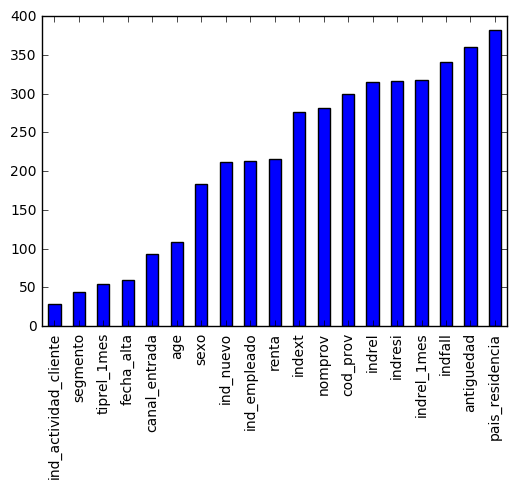

In [29]:
df_ranking.sort_values('total')['total'].plot(kind='bar')

## Conclusion

This last step of summing up the rankings might not make much sense, but I was curious to see the consistency of importance each variable exhibits. It seems to me that there is a high degree of consistency, e.g. 'ind_actividad'cliente' is almost always in the top 3 for all products. This might give you a sense of how to consider the features when you use a classification or clustering algorithm.